# Sentiment Analysis of Android App Reviews

### The primary objective of this project is to build a robust NLP pipeline to classify customer reviews of Android Galaxy products as either positive or negative. With the increasing volume of user-generated content on digital platforms, sentiment analysis has become a critical tool for extracting meaningful insights from textual data. In this project, the dataset was collected from Reddit, where users frequently share their experiences and opinions about Android Galaxy devices. This project utilizes both traditional machine learning models and deep learning techniques to compare their performance in sentiment classification.

In [ ]:
!pip uninstall -y numpy scipy gensim
!pip install numpy==1.25.1 scipy==1.10.1 gensim==4.3.2

Found existing installation: numpy 1.25.1
Uninstalling numpy-1.25.1:
  Successfully uninstalled numpy-1.25.1
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
  Using cached numpy-1.25.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached numpy-1.25.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
ERROR: pip's dependency resolver does not currently take into account all 

In [ ]:
# Basic Imports
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Explore the Dataset


In [ ]:
# Load the CSV file
dataset = pd.read_csv('Android_Galaxy_comments.csv')

# Count the number of instances in each class
dataset.shape, dataset['label'].value_counts()

((1000, 2),
 label
 negative    752
 positive    173
 neutral      75
 Name: count, dtype: int64)

In [ ]:
dataset.head(10)

,comment_text,label
0,"This is peak ""my daydreams and misunderstandin...",negative
1,Did AI write this?,negative
2,Lad bought a $1400 phone and is disappointed t...,negative
3,I have no idea how you don't find it a substan...,negative
4,"ChatGPT was your friend, eh?",negative
5,This isn't an airport. You don't need to annou...,positive
6,Thanks chatgpt,positive
7,We got npc bot rants before gta6,negative
8,Should have done some more research before buy...,negative
9,> This release feels more like an incremental ...,negative


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  1000 non-null   object
 1   label         1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
dataset.describe()

,comment_text,label
count,1000,1000
unique,999,3
top,And the crowd goes mild,negative
freq,2,752


In [ ]:
dataset.isnull().sum()

,0
comment_text,0
label,0


# Data preprocessing

In [ ]:
dataset = dataset[dataset['label'] != 'neutral']

In [ ]:
dataset['label'].value_counts()

,count
label,
negative,752
positive,173


In [ ]:
# Separate the dataset into positive and negative classes
df_negative = dataset[dataset['label'] == 'negative']
df_positive = dataset[dataset['label'] == 'positive']

# Upsample the positive class to match the size of the negative class
df_positive_upsampled = resample(
    df_positive,
    replace=True,                 # Sample with replacement
    n_samples=len(df_negative),   # Match number of samples in the negative class
    random_state=42               # Ensure reproducibility
)

# Combine the negative class with the upsampled positive class
balanced_dataset = pd.concat([df_negative, df_positive_upsampled])

# Shuffle the dataset to mix positive and negative samples
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the distribution of labels to confirm balance
print(balanced_dataset['label'].value_counts())

label
negative    752
positive    752
Name: count, dtype: int64


# Text Preprossing

In [ ]:
def preprocess_text(text):

    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Combine words back into a single string
    preprocessed_text = ' '.join(words)


    return preprocessed_text

In [ ]:
# Apply the preprocessing function to each comment in the 'comment_text' column
#This includes cleaning, tokenization, stopword removal, and lemmatization
balanced_dataset['cleand_text'] = balanced_dataset['comment_text'].apply(preprocess_text)

# Display the first 5 rows of the dataset to inspect the cleaned text
balanced_dataset.head()

,comment_text,label,cleand_text
0,Every time I read a review for a great not-Sam...,negative,every time read review great samsung pixel and...
1,oh joy another 1% improvement,positive,oh joy another improvement
2,Cheaping out on components your sister subsidi...,negative,cheaping component sister subsidiary make trag...
3,This is truly the pinnacle of innovation!,positive,truly pinnacle innovation
4,so more pronouced camera rings.. that's it?,negative,pronouced camera ring


In [ ]:
print(balanced_dataset.columns)

Index(['comment_text', 'label', 'cleand_text'], dtype='object')


# Text Representations

In [ ]:
def text_representations(X_train_text, X_test_text, representation_type, vector_size=100):
    # Bag of Words representation
    if representation_type == 'bow':
        vectorizer = CountVectorizer()
        # Fit the vectorizer on training data and transform both train and test sets
        X_train_transformed = vectorizer.fit_transform(X_train_text)
        X_test_transformed = vectorizer.transform(X_test_text)
        return X_train_transformed, X_test_transformed, vectorizer

    # TF-IDF representation
    elif representation_type == 'tfidf':
        vectorizer = TfidfVectorizer()
        # Fit the vectorizer on training data and transform both train and test sets
        X_train_transformed = vectorizer.fit_transform(X_train_text)
        X_test_transformed = vectorizer.transform(X_test_text)
        return X_train_transformed, X_test_transformed, vectorizer

    # Word2Vec representation
    elif representation_type == 'word2vec':
        # Tokenize each sentence (split by whitespace)
        train_tokenized = [sentence.split() for sentence in X_train_text]
        test_tokenized = [sentence.split() for sentence in X_test_text]

        # Train Word2Vec model on training data
        model = Word2Vec(train_tokenized, vector_size=vector_size, window=5, min_count=1, workers=4)

        # Average word vectors for each sentence in training data
        X_train_transformed = np.array([
            np.mean([model.wv[word] for word in sentence if word in model.wv], axis=0)
            if any(word in model.wv for word in sentence) else np.zeros(vector_size)
            for sentence in train_tokenized
        ])

        # Average word vectors for each sentence in test data
        X_test_transformed = np.array([
            np.mean([model.wv[word] for word in sentence if word in model.wv], axis=0)
            if any(word in model.wv for word in sentence) else np.zeros(vector_size)
            for sentence in test_tokenized
        ])

        return X_train_transformed, X_test_transformed, model

    # Raise an error for invalid representation types
    else:
        raise ValueError("Invalid representation type. Choose 'bow', 'tfidf', or 'word2vec'.")



=== Logistic Regression with BOW ===
Accuracy:  89.82%
Precision: 86.00%
Recall:    95.13%
F1-Score:  90.34%


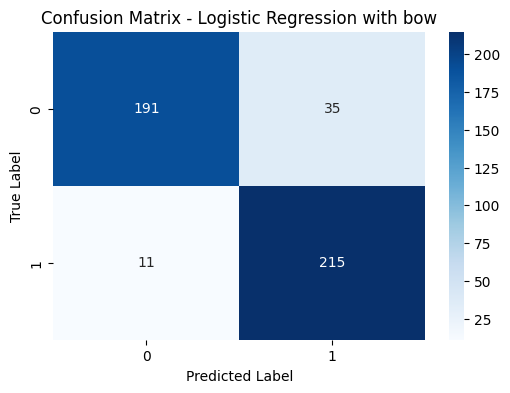


=== Logistic Regression with TFIDF ===
Accuracy:  89.82%
Precision: 87.82%
Recall:    92.48%
F1-Score:  90.09%


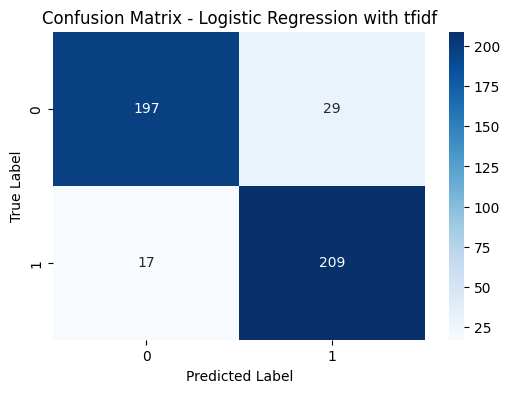


=== Logistic Regression with WORD2VEC ===
Accuracy:  48.23%
Precision: 48.44%
Recall:    54.87%
F1-Score:  51.45%


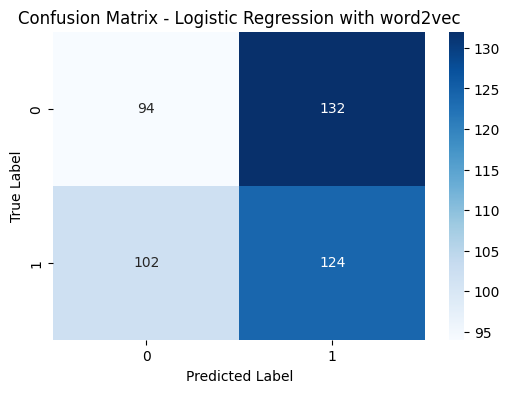


=== Support Vector Classifier with BOW ===
Accuracy:  89.16%
Precision: 84.17%
Recall:    96.46%
F1-Score:  89.90%


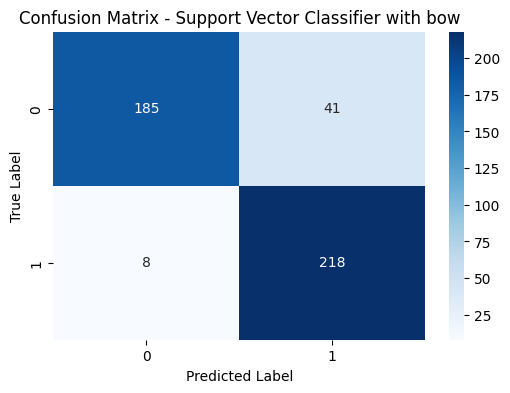


=== Support Vector Classifier with TFIDF ===
Accuracy:  97.12%
Precision: 99.08%
Recall:    95.13%
F1-Score:  97.07%


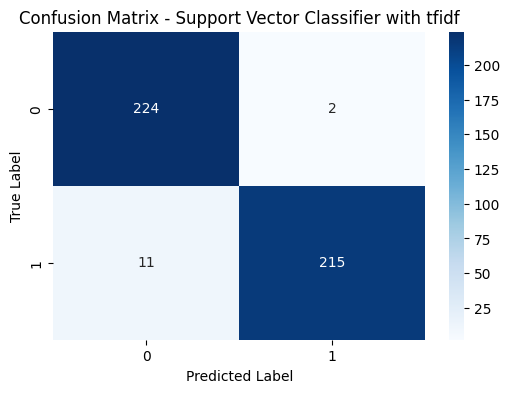


=== Support Vector Classifier with WORD2VEC ===
Accuracy:  47.79%
Precision: 48.05%
Recall:    54.42%
F1-Score:  51.04%


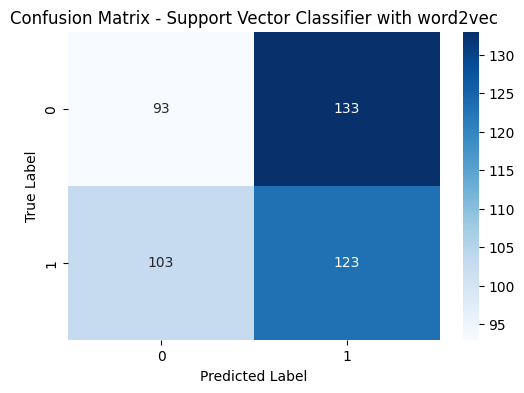


=== Random Forest Classifier with BOW ===
Accuracy:  90.49%
Precision: 85.88%
Recall:    96.90%
F1-Score:  91.06%


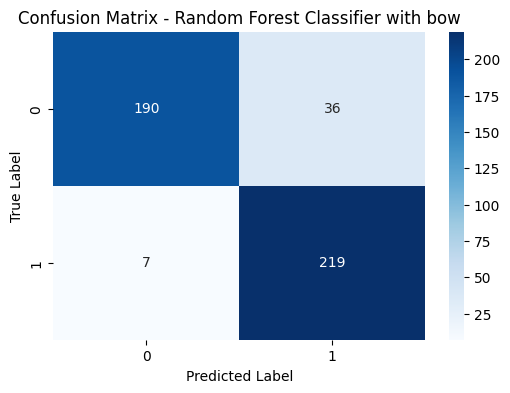


=== Random Forest Classifier with TFIDF ===
Accuracy:  91.15%
Precision: 86.90%
Recall:    96.90%
F1-Score:  91.63%


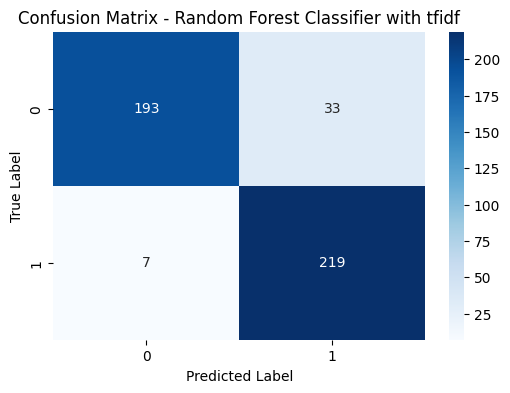


=== Random Forest Classifier with WORD2VEC ===
Accuracy:  94.91%
Precision: 94.71%
Recall:    95.13%
F1-Score:  94.92%


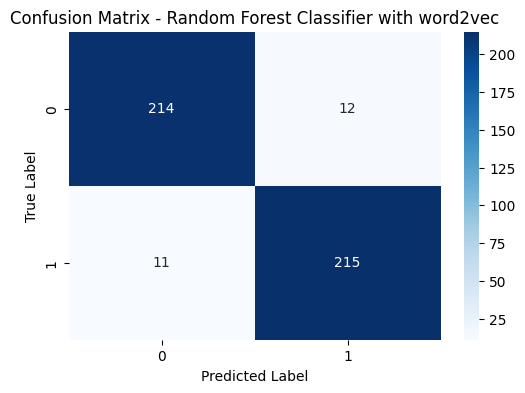

In [ ]:
# Define text representation techniques to evaluate
representations = ['bow', 'tfidf', 'word2vec']

# Define traditional ML classification models with class weight balancing
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', class_weight='balanced'),
    'Support Vector Classifier': SVC(class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced')
}

# Encode labels (e.g., 'positive', 'negative') into numerical format
le = LabelEncoder()
y = le.fit_transform(balanced_dataset['label'])

# Split the dataset into training and testing sets (stratified to maintain class balance)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    balanced_dataset['cleand_text'], y, stratify=y, test_size=0.3, random_state=42
)

# Loop through each model and each text representation technique
for algo_name, model in models.items():
    for rep in representations:
        print(f"\n=== {algo_name} with {rep.upper()} ===")

        # Apply the chosen text representation method
        X_train, X_test, _ = text_representations(X_train_text, X_test_text, rep)

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Print evaluation metrics
        print(f"Accuracy:  {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
        print(f"Recall:    {recall_score(y_test, y_pred) * 100:.2f}%")
        print(f"F1-Score:  {f1_score(y_test, y_pred) * 100:.2f}%")

        # Generate and display the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {algo_name} with {rep}')
        plt.show()


# Modeling

In [ ]:
# Extract cleaned text and labels
texts = balanced_dataset['cleand_text'].values
labels = balanced_dataset['label'].values

# Encode labels into integers, then convert to one-hot vectors
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
y = to_categorical(labels_encoded)

# Split the dataset into training and testing sets (stratified)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, stratify=y, test_size=0.3, random_state=42
)

# Set tokenizer and padding parameters
max_words = 10000   # Max number of words to keep (vocabulary size)
max_len = 100       # Max length of each sequence (number of tokens)

# Initialize tokenizer and fit it on the training text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to ensure consistent input length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Word embeddings
model.add(Bidirectional(LSTM(64)))  # Bidirectional LSTM layer with 64 units
model.add(Dropout(0.5))             # Dropout to reduce overfitting
model.add(Dense(64, activation='relu'))  # Dense layer with ReLU activation
model.add(Dense(2, activation='softmax'))  # Output layer for 2 classes

# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Further split training data into train and validation sets
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42
)

# Define early stopping to stop training when validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop]
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 652ms/step - accuracy: 0.5351 - loss: 0.6919 - val_accuracy: 0.6066 - val_loss: 0.6875
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.6377 - loss: 0.6839 - val_accuracy: 0.6919 - val_loss: 0.6669
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 829ms/step - accuracy: 0.7027 - loss: 0.6556 - val_accuracy: 0.6919 - val_loss: 0.6226
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.7838 - loss: 0.5839 - val_accuracy: 0.7725 - val_loss: 0.5541
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - accuracy: 0.8444 - loss: 0.4449 - val_accuracy: 0.7630 - val_loss: 0.4379
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.9011 - loss: 0.2636 - val_accuracy: 0.8389 - val_loss: 0.3533
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.9516 - loss: 0.1559 - val_accuracy: 0.8483 - val_loss: 0.3318
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - accuracy: 0.9741 - loss: 0.0868 - val_accuracy: 0.8578 - val_loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step

=== LSTM CLASSIFICATION REPORT (%) ===
Class          Precision      Recall    F1-Score     Support
------------------------------------------------------------
negative           89.32       81.42       85.19         226
positive           82.93       90.27       86.44         226

Overall Accuracy: 85.84%


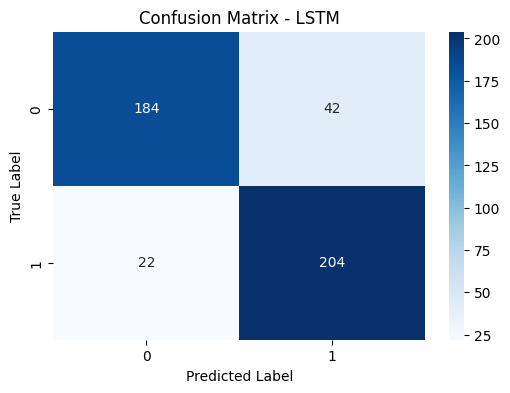

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161,608 (15.88 MB)

 Trainable params: 1,387,202 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,774,406 (10.58 MB)

In [ ]:
# Predict class probabilities on the test set
y_pred_prob = model.predict(X_test_pad)

# Convert probabilities to class predictions (using the index of the highest probability)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded true labels back to class indices
y_true = np.argmax(y_test, axis=1)

# Includes precision, recall, F1-score, and support for each class
report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# Print classification report in percentage format
print("\n=== LSTM CLASSIFICATION REPORT (%) ===")
print(f"{'Class':<12}{'Precision':>12}{'Recall':>12}{'F1-Score':>12}{'Support':>12}")
print("-" * 60)

for label in le.classes_:
    precision = report[label]['precision'] * 100
    recall = report[label]['recall'] * 100
    f1 = report[label]['f1-score'] * 100
    support = int(report[label]['support'])
    print(f"{label:<12}{precision:12.2f}{recall:12.2f}{f1:12.2f}{support:12}")

# Print overall accuracy of the model
accuracy = report['accuracy'] * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")

# Confusion matrix visualization =====
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM')
plt.show()

# Display model architecture summary
model.summary()
